In [4]:
import matplotlib.pyplot as plt
import numpy as np
from struct import unpack
from sklearn import cluster
import datetime
import hdbscan
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, normalize, MinMaxScaler, StandardScaler
from tsnecuda import TSNE
from struct import pack
from sklearn_extra.cluster import KMedoids

def transform(_in) :
    #vg / h 분리
    np_vgh = _in
    np_vg = np.delete(_in, 2, axis = 1) #3열 삭제
    np_h = (_in[:,2]).reshape(-1,1) #3열 추출
    #log(h)
    np_logh = np.log(np_h[::]+1)
    #logh 병합
    np_vgh_logh = np.hstack((np_vgh,np_logh))
    # normalized v,g,h,logh
    np_normal_l1_vgh_logh = normalize(np_vgh_logh, axis=0, norm='l1')
    np_normal_l2_vgh_logh = normalize(np_vgh_logh, axis=0, norm='l2')
    np_normal_max_vgh_logh = normalize(np_vgh_logh, axis=0, norm='max')
    #tr standardization
    std_scaler = StandardScaler()
    fitted = std_scaler.fit(np_vgh_logh)
    np_std_vgh_logh = std_scaler.transform(np_vgh_logh)
    #print(np_std_vgh_logh)
    #tr min-max scale
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(np_vgh_logh)
    np_min_max_vgh_logh=min_max_scaler.transform(np_vgh_logh)
    #print(np_min_max_vgh_logh)
    #yeo-johnson
    pt_vgh_logh = PowerTransformer(method='yeo-johnson')
    pt_vgh_logh.fit(np_vgh_logh)
    np_yeojohnson_vgh_logh = pt_vgh_logh.transform(np_vgh_logh)

    ret = []
    ret.append(  _in                                  )  
    ret.append(  np.delete(np_vgh_logh, 2, axis = 1)                   )
    ret.append(  np.hstack((np_normal_l1_vgh_logh[:,[0,1]], np_h))     )
    ret.append(  np.hstack((np_normal_l1_vgh_logh[:,[0,1]], np_logh))  ) 
    ret.append(  np.delete(np_normal_l1_vgh_logh, 2, axis = 1)         )
    ret.append(  np.delete(np_normal_l1_vgh_logh, 3, axis = 1)         )
    ret.append(  np.hstack((np_normal_l2_vgh_logh[:,[0,1]], np_h))     )
    ret.append(  np.hstack((np_normal_l2_vgh_logh[:,[0,1]], np_logh))  )
    ret.append(  np.delete(np_normal_l2_vgh_logh, 2, axis = 1)         )  
    ret.append(  np.delete(np_normal_l2_vgh_logh, 3, axis = 1)         )
    ret.append(  np.hstack((np_normal_max_vgh_logh[:,[0,1]], np_h))    )     
    ret.append(  np.hstack((np_normal_max_vgh_logh[:,[0,1]], np_logh)) )    
    ret.append(  np.delete(np_normal_max_vgh_logh, 2, axis = 1)        )
    ret.append(  np.delete(np_normal_max_vgh_logh, 3, axis = 1)        ) 
    ret.append(  np.hstack((np_std_vgh_logh[:,[0,1]], np_h))           )
    ret.append(  np.hstack((np_std_vgh_logh[:,[0,1]], np_logh))        )
    ret.append(  np.delete(np_std_vgh_logh, 2, axis = 1)               )   
    ret.append(  np.delete(np_std_vgh_logh, 3, axis = 1)               )
    ret.append(  np.hstack((np_min_max_vgh_logh[:,[0,1]], np_h))       )     
    ret.append(  np.hstack((np_min_max_vgh_logh[:,[0,1]], np_logh))    )     
    ret.append(  np.delete(np_min_max_vgh_logh, 2, axis = 1)           )     
    ret.append(  np.delete(np_min_max_vgh_logh, 3, axis = 1)           )       
    ret.append(  np.hstack((np_yeojohnson_vgh_logh[:,[0,1]], np_h))    )         
    ret.append(  np.hstack((np_yeojohnson_vgh_logh[:,[0,1]], np_logh)) )          
    ret.append(  np.delete(np_yeojohnson_vgh_logh, 2, axis = 1)        )         
    ret.append(  np.delete(np_yeojohnson_vgh_logh, 3, axis = 1)        )      
    
    return ret

def binaryFileWrite2DHist(filename, hist_cluster) :
    si = len(hist_cluster[0])
    sj = len(hist_cluster)
    with open(filename, 'wb') as fp:
        for i in range(si):
            for j in range(sj):
                fp.write(pack('<i', hist_cluster[i][j]))   
                
def _TSNE(learning_rate, data) :
    model = TSNE(learning_rate=learning_rate)
    print("TSNE calc : ", end='')
    startTime = datetime.datetime.now()
    transformed = model.fit_transform(data)
    endTime = datetime.datetime.now()
    diffTime = endTime-startTime
    exeTime = diffTime.total_seconds() * 1000
    print(exeTime,'ms')
    return transformed

def kmeans(k, targetdata, originaldata, w, h, bfilename):
    startTime = datetime.datetime.now()
    kmeans = cluster.KMeans(n_clusters=k, random_state=0).fit(targetdata)
    endTime = datetime.datetime.now()
    diffTime = endTime-startTime
    exeTime = diffTime.total_seconds() * 1000
    
    #print(targetdata, targetdata.shape)
    #print(originaldata, originaldata.shape)
    
    hist_cluster=[[-1 for x in range(w)] for x in range(h)]
    
    for idx in range(len(targetdata)):
        hist_cluster[originaldata[idx][0]][originaldata[idx][1]]=kmeans.labels_[idx]
            
    model = bfilename
    etc = "n_clusters_%d"%(k)
    
    H = np.array(hist_cluster)
    H = H[::]+1
    plt.imshow(H[::-1])
    plt.title("%s K-Mean %d clusters, \ncalctime : %.2f ms"%(dataset, k, exeTime))
    #plt.show()
    print('KMEANS Time : ', exeTime,'ms', ', #clusters : ', k)
    plt.savefig("kmeans_png/%s_%s_1.png"%(model, etc), dpi=300)
    
    print(exeTime,'ms')
    
    binaryFileWrite2DHist("kmeans_bin/%s_%s.bin"%(model, etc), H) 
    
    return kmeans.labels_

def kmedoids(k, _metric, targetdata, originaldata, w, h, bfilename) :
    startTime = datetime.datetime.now()
    
    kmedoids = KMedoids(metric=_metric, n_clusters=k).fit(targetdata)
    endTime = datetime.datetime.now()
    diffTime = endTime-startTime
    exeTime = diffTime.total_seconds() * 1000
    
    #print(targetdata, targetdata.shape)
    #print(originaldata, originaldata.shape)
    
    hist_cluster=[[-1 for x in range(w)] for x in range(h)]
    
    for idx in range(len(targetdata)):
        hist_cluster[originaldata[idx][0]][originaldata[idx][1]]=kmedoids.labels_[idx]
            
    model = bfilename
    etc = "metric_%s_n_clusters_%d"%(_metric, k)
    
    H4 = np.array(hist_cluster)
    H4 = H4[::]+1
    plt.imshow(H4[::-1])
    plt.title("%s KMedoids %d clusters, metric : %s, \ncalctime : %.2f ms"%(dataset, k, _metric, exeTime))
    #plt.show()
    print('KMedoids Time : ', exeTime,'ms', ', #clusters : ', k)
    plt.savefig("kmedoids_png/%s_%s_1.png"%(model, etc), dpi=300)
    
    print(exeTime,'ms')
    
    binaryFileWrite2DHist("kmedoids_bin/%s_%s.bin"%(model, etc), H4) 
    
    return kmedoids.labels_

def dbscan(_eps, targetdata, originaldata, w, h, bfilename):
    startTime = datetime.datetime.now()
    dbscan = cluster.DBSCAN(eps=_eps).fit(targetdata)

    endTime = datetime.datetime.now()
    diffTime = endTime-startTime
    exeTime = diffTime.total_seconds() * 1000

    hist_dbscan_cluster=[[-1 for x in range(w)] for x in range(h)]
    
    for idx in range(len(originaldata)):
        _i = originaldata[idx][0]
        _j = originaldata[idx][1]
        hist_dbscan_cluster[_i][_j]=dbscan.labels_[idx]
        
    model = bfilename
    etc = "eps_%.2f"%(_eps)

    H2 = np.array(hist_dbscan_cluster)
    plt.imshow(H2[::-1])
    plt.title("%s DBSCAN eps : %f, \ncalctime : %.2f ms"%(dataset, _eps, exeTime))
    #plt.show()
    plt.savefig("dbscan_png/%s_%s_1.png"%(model, etc), dpi=300)
    print('DBSCAN Time : ', exeTime,'ms', ', eps : ',_eps)
    
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    print( "# of clusters : ", n_clusters_   )
    
    binaryFileWrite2DHist("dbscan_bin/%s_%s.bin"%(model, etc), H2)    
    
    return dbscan.labels_

def Hdbscan(_min_cluster_size, _min_samples, _alpha, targetdata, originaldata, w, h, bfilename):
    startTime = datetime.datetime.now()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=_min_cluster_size, min_samples =_min_samples, alpha=_alpha).fit(targetdata)

    endTime = datetime.datetime.now()
    diffTime = endTime-startTime
    exeTime = diffTime.total_seconds() * 1000
    #print(clusterer.labels_)
    #print(max(clusterer.labels_))
    #print(targetdata)
    #print(originaldata)
    #print(clusterer.labels_)

    hist_cluster_hdbscan=[[-1 for x in range(w)] for x in range(h)]
    
    for idx in range(len(originaldata)):
        _i = originaldata[idx][0]
        _j = originaldata[idx][1]
        hist_cluster_hdbscan[_i][_j]=clusterer.labels_[idx]

        
    model = bfilename
    etc = "minsize_%.1f_minsample_%.1f_alpha_%.1f"%(_min_cluster_size, _min_samples, _alpha)
    
    
    n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
    print(  "cluster num : ", n_clusters_   )
    
    H3 = np.array(hist_cluster_hdbscan)
    plt.imshow(H3[::-1])
    plt.title("HDBSCAN [%s], min_cluster_size : %d, result cluster number : %d, \ncalc time: %.2f ms"%(dataset, _min_cluster_size, n_clusters_, exeTime))
    plt.savefig("hdbscan_png/%s_%s_1.png"%(model, etc), dpi=300)
    plt.show()
    print(exeTime,'ms')    
    
    clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
    
    plt.savefig("hdbscan_png/%s_%s_1.5.png"%(model, etc), dpi=300)
    plt.show()
                                   
    viewTSNEClustering(targetdata, clusterer.labels_, "hdbscan_png/%s_%s_2.png"%(model, etc) )
    
    
    binaryFileWrite2DHist("hdbscan_bin/%s_%s.bin"%(model, etc), H3) 
    
    print(bfilename)
    
    return clusterer.labels_

def viewTSNEClustering(_tsnedata, _clusterlabel, filename) :
    plt.scatter(*_tsnedata.T, s=1, c=_clusterlabel)
    plt.savefig(filename, dpi=300)
    plt.show()

def save_tsne_result(tsnedata, path, filename):
    np.savetxt("%s/%s.csv"%(path, filename), tsnedata, fmt='%f', delimiter=',')

bonsai256X256X256B_0_sparse_vgh	TSNE calc : 1040.0739999999998 ms
bonsai256X256X256B_1_sparse_vglogh	TSNE calc : 885.239 ms
bonsai256X256X256B_2_sparse_n_l1_vg_h	TSNE calc : 1048.14 ms
bonsai256X256X256B_3_sparse_n_l1_vg_logh	TSNE calc : 1037.2140000000002 ms
bonsai256X256X256B_4_sparse_n_l1_vgh	TSNE calc : 868.271 ms
bonsai256X256X256B_5_sparse_n_l1_vglogh	TSNE calc : 870.152 ms
bonsai256X256X256B_6_sparse_n_l2_vg_h	TSNE calc : 984.897 ms
bonsai256X256X256B_7_sparse_n_l2_vg_logh	TSNE calc : 944.0269999999999 ms
bonsai256X256X256B_8_sparse_n_l2_vgh	TSNE calc : 910.2170000000001 ms
bonsai256X256X256B_9_sparse_n_l2_vglogh	TSNE calc : 858.246 ms
bonsai256X256X256B_10_sparse_n_max_vg_h	TSNE calc : 903.3489999999999 ms
bonsai256X256X256B_11_sparse_n_max_vg_logh	TSNE calc : 879.559 ms
bonsai256X256X256B_12_sparse_n_max_vgh	TSNE calc : 937.216 ms
bonsai256X256X256B_13_sparse_n_max_vglogh	TSNE calc : 849.87 ms
bonsai256X256X256B_14_sparse_std_vg_h	TSNE calc : 869.8620000000001 ms
bonsai256X256

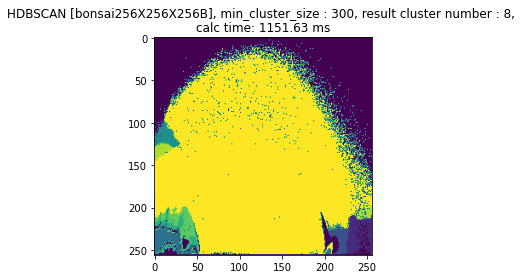

1151.6280000000002 ms


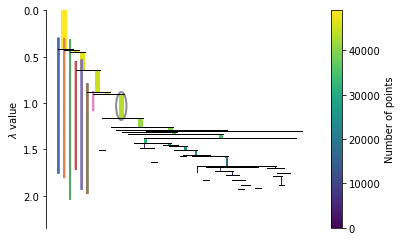

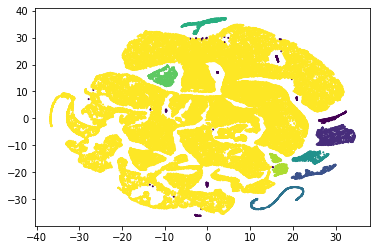

bonsai256X256X256B_0_sparse_vgh
cluster num :  7


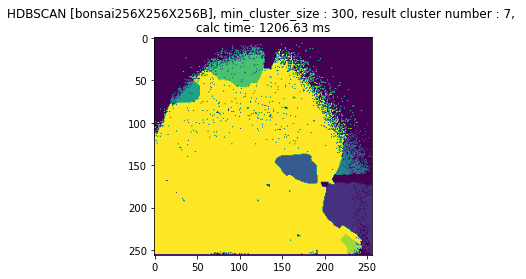

1206.634 ms


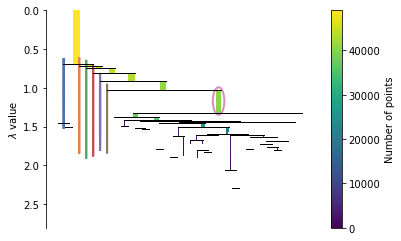

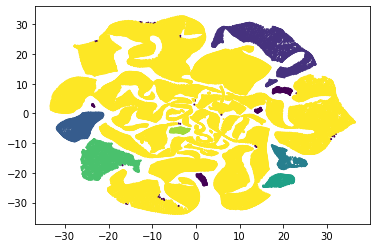

bonsai256X256X256B_1_sparse_vglogh
cluster num :  44


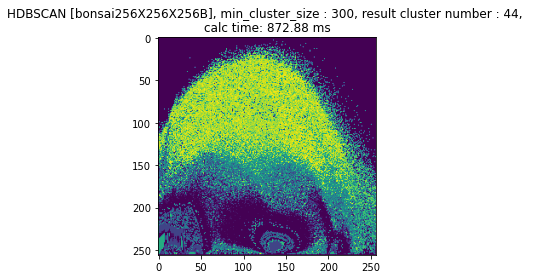

872.88 ms


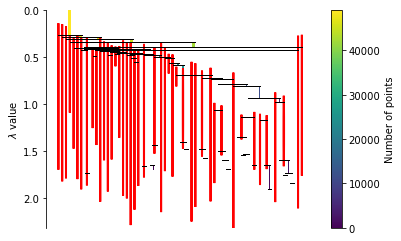

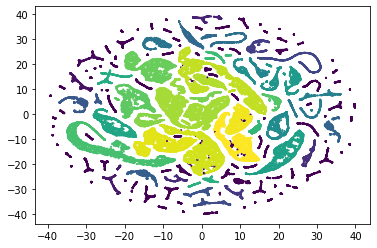

bonsai256X256X256B_2_sparse_n_l1_vg_h
cluster num :  49


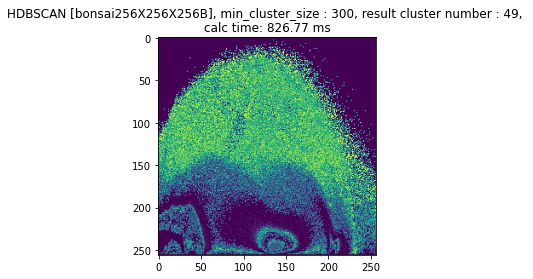

826.769 ms


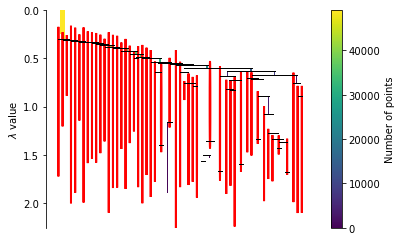

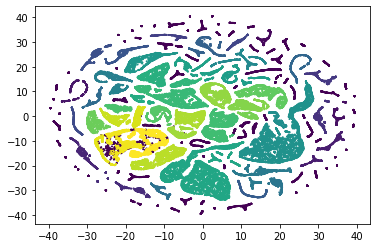

bonsai256X256X256B_3_sparse_n_l1_vg_logh
cluster num :  16


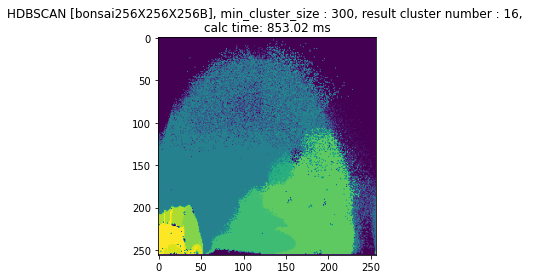

853.02 ms


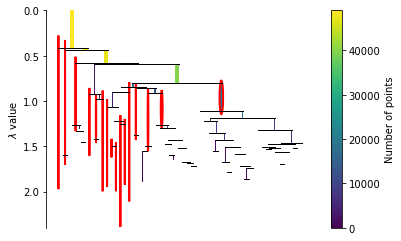

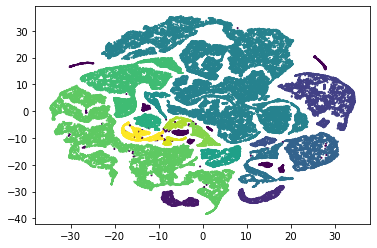

bonsai256X256X256B_4_sparse_n_l1_vgh
cluster num :  7


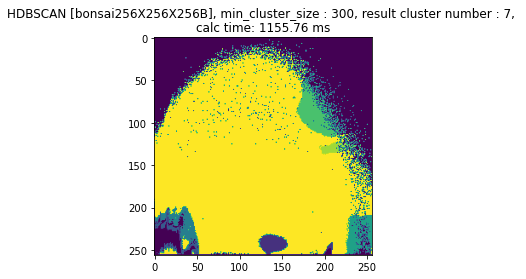

1155.7640000000001 ms


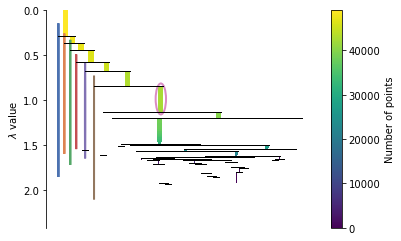

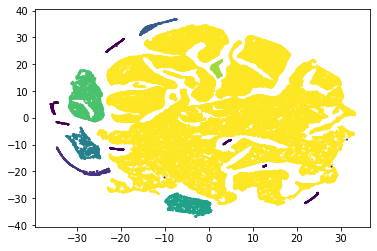

bonsai256X256X256B_5_sparse_n_l1_vglogh
cluster num :  38


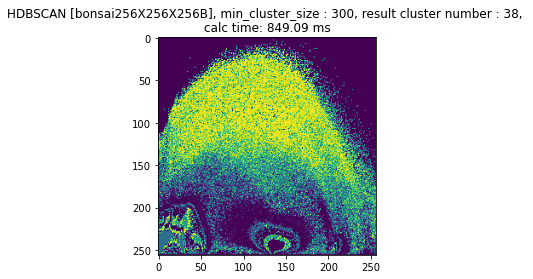

849.0889999999999 ms


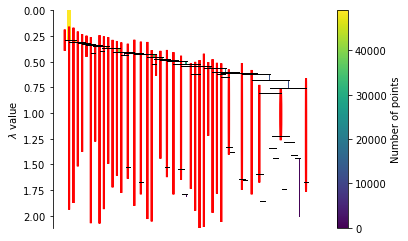

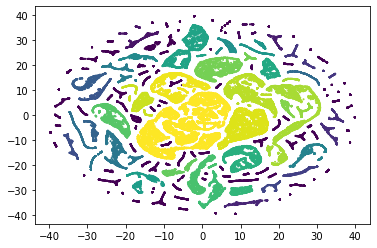

bonsai256X256X256B_6_sparse_n_l2_vg_h
cluster num :  49


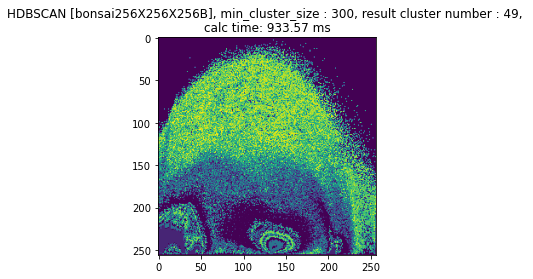

933.571 ms


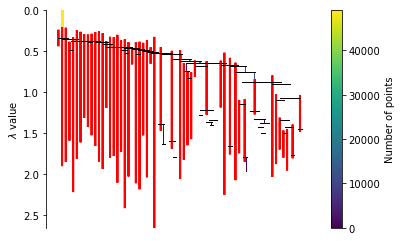

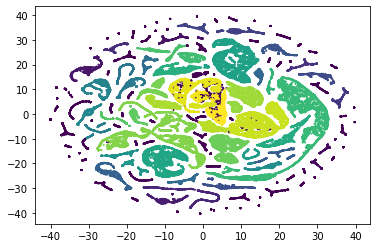

bonsai256X256X256B_7_sparse_n_l2_vg_logh
cluster num :  24


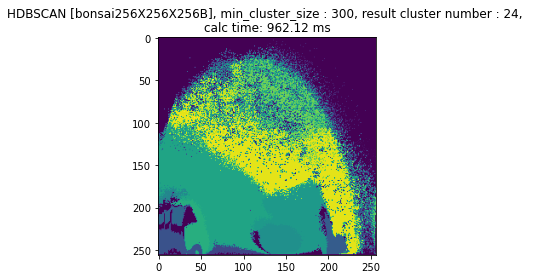

962.121 ms


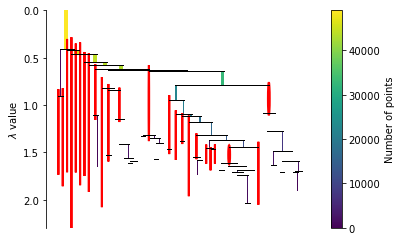

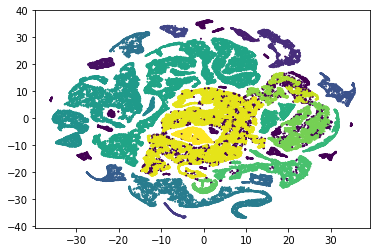

bonsai256X256X256B_8_sparse_n_l2_vgh
cluster num :  2


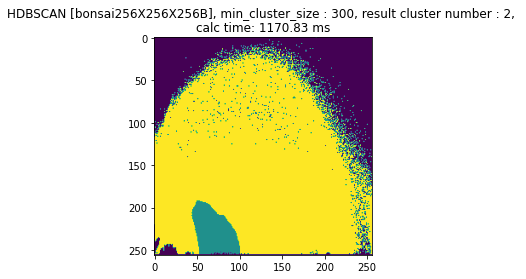

1170.826 ms


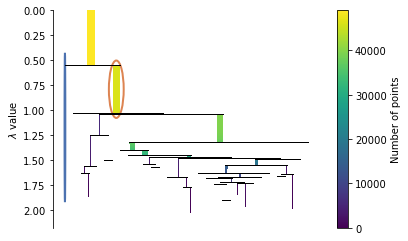

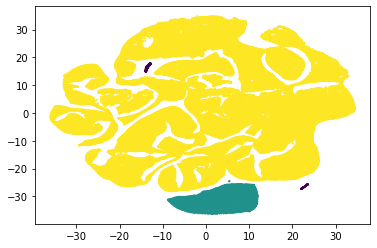

bonsai256X256X256B_9_sparse_n_l2_vglogh
cluster num :  50


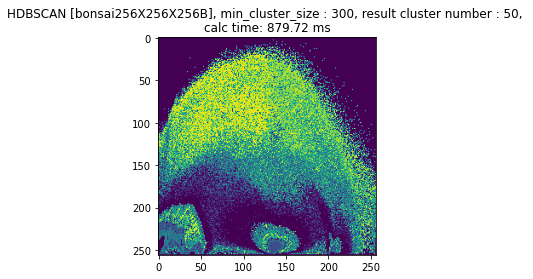

879.718 ms


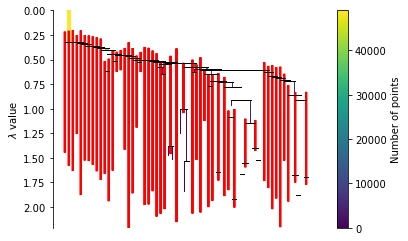

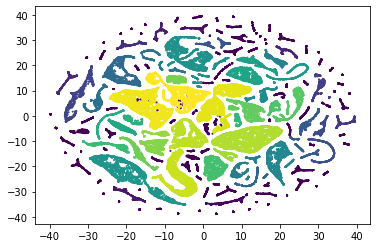

bonsai256X256X256B_10_sparse_n_max_vg_h
cluster num :  51


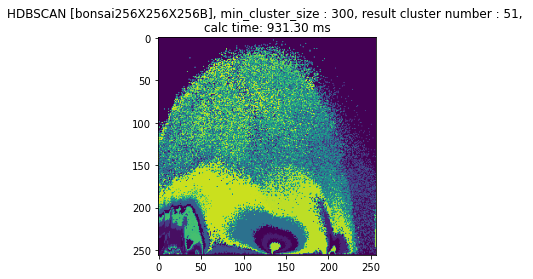

931.3019999999999 ms


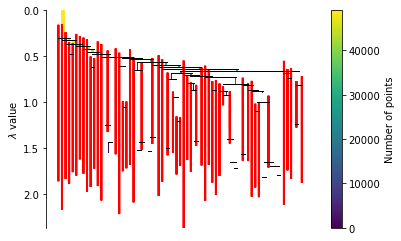

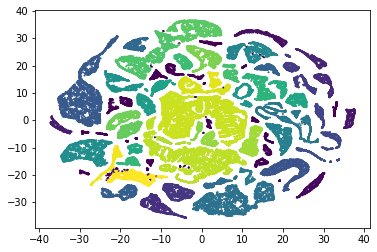

bonsai256X256X256B_11_sparse_n_max_vg_logh
cluster num :  20


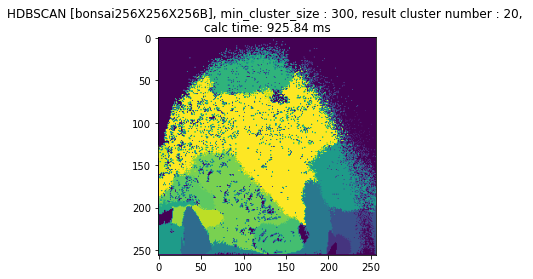

925.843 ms


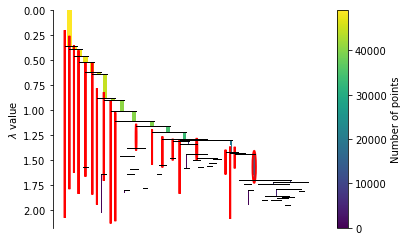

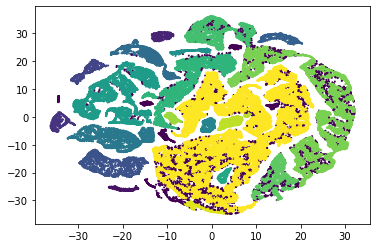

bonsai256X256X256B_12_sparse_n_max_vgh
cluster num :  4


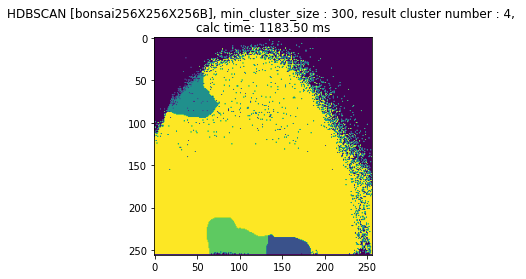

1183.501 ms


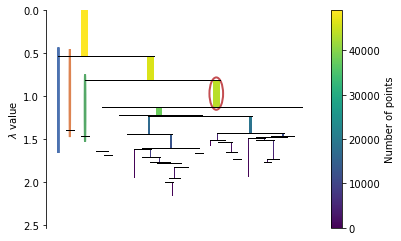

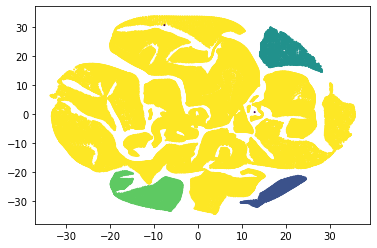

bonsai256X256X256B_13_sparse_n_max_vglogh
cluster num :  50


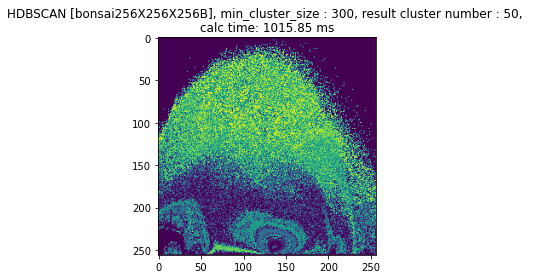

1015.8450000000001 ms


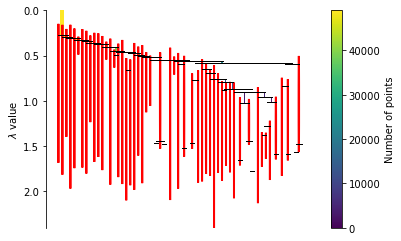

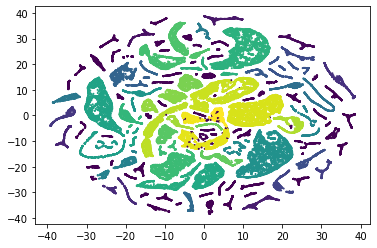

bonsai256X256X256B_14_sparse_std_vg_h
cluster num :  28


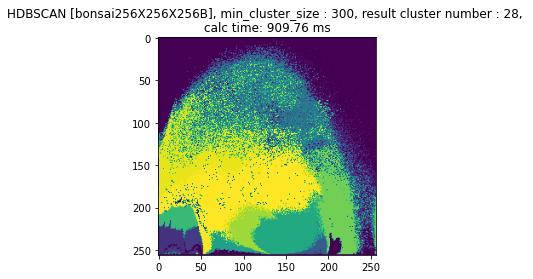

909.759 ms


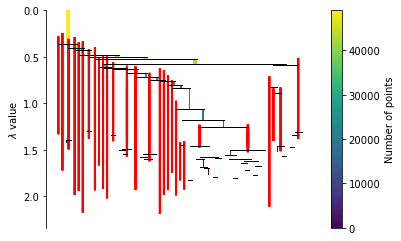

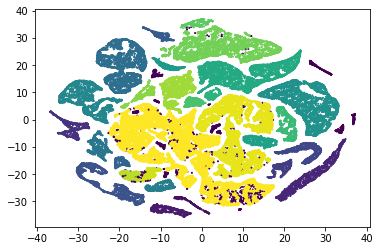

bonsai256X256X256B_15_sparse_std_vg_logh
cluster num :  22


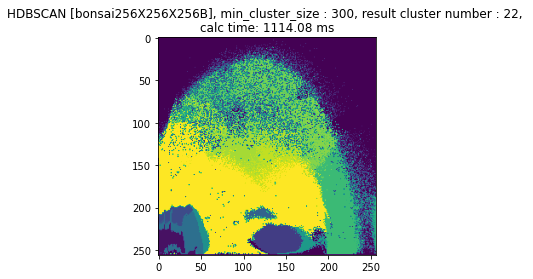

1114.076 ms


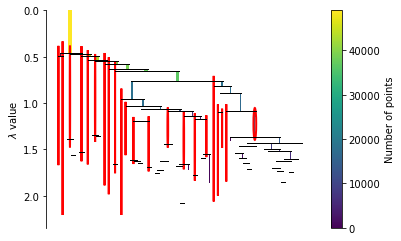

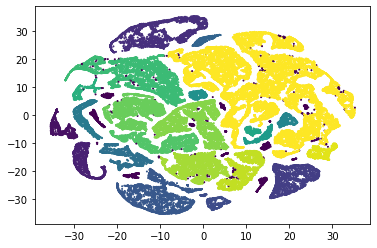

bonsai256X256X256B_16_sparse_std_vgh
cluster num :  8


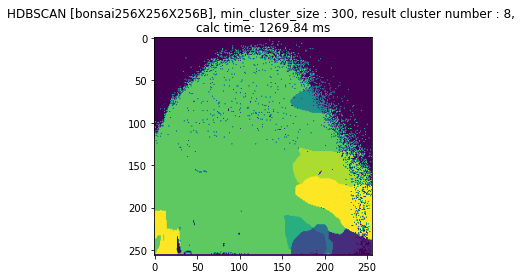

1269.844 ms


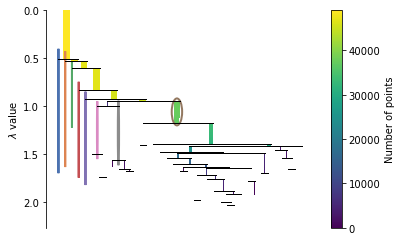

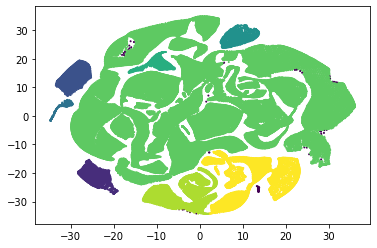

bonsai256X256X256B_17_sparse_std_vglogh
cluster num :  46


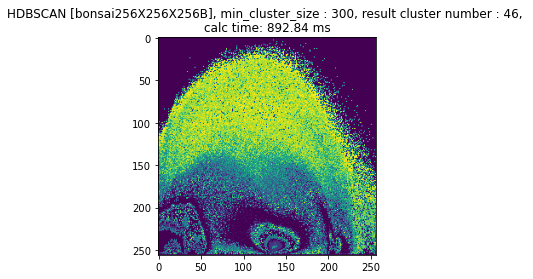

892.838 ms


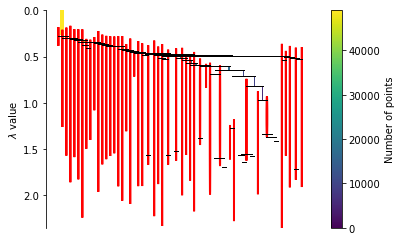

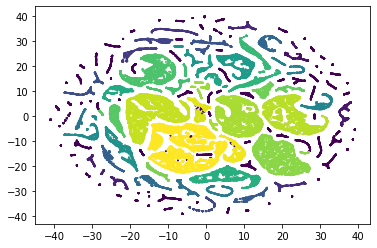

bonsai256X256X256B_18_sparse_mm_vg_h
cluster num :  47


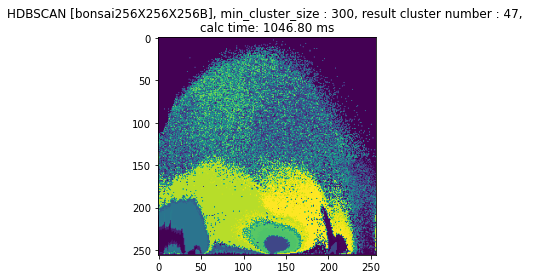

1046.796 ms


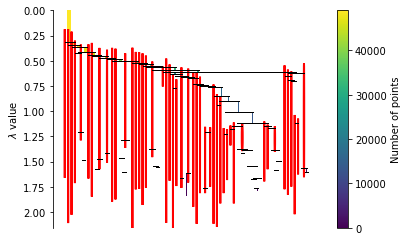

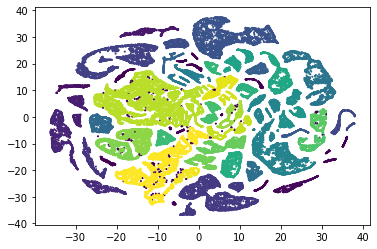

bonsai256X256X256B_19_sparse_mm_vg_logh
cluster num :  4


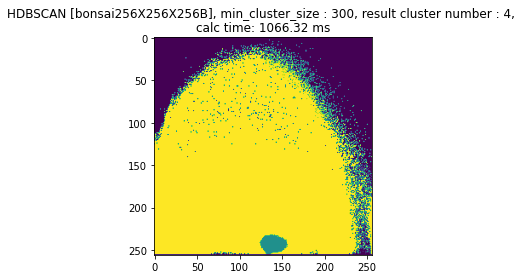

1066.322 ms


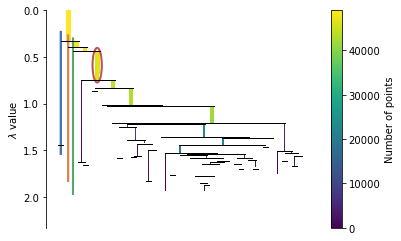

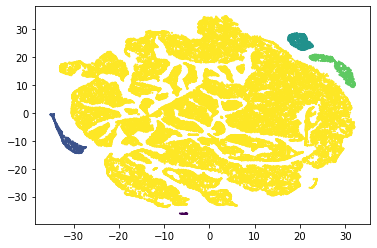

bonsai256X256X256B_20_sparse_mm_vgh
cluster num :  2


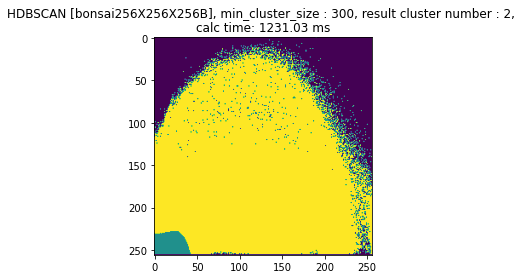

1231.027 ms


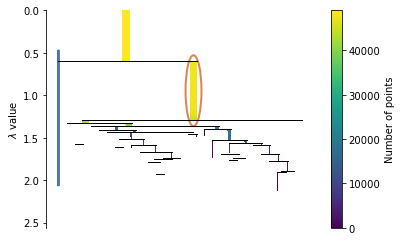

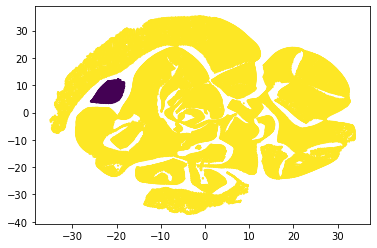

bonsai256X256X256B_21_sparse_mm_vglogh
cluster num :  51


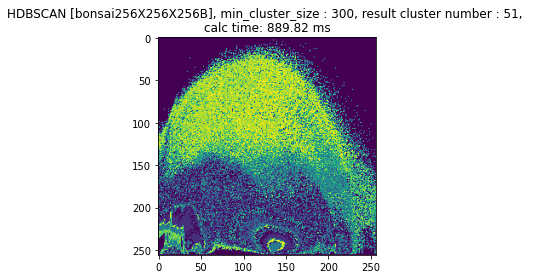

889.822 ms


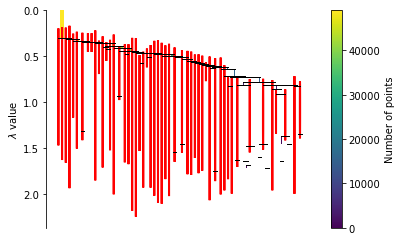

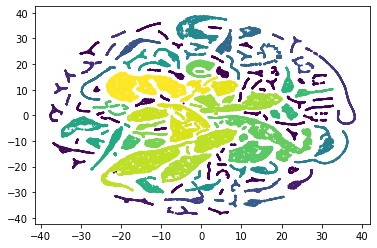

bonsai256X256X256B_22_sparse_pt_vg_h
cluster num :  29


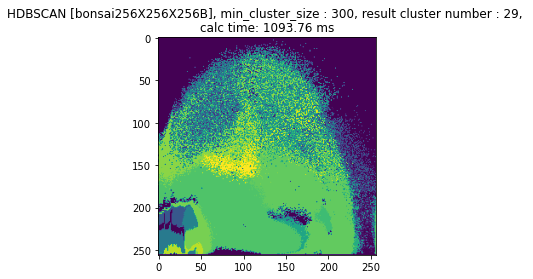

1093.764 ms


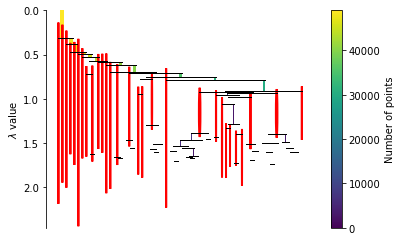

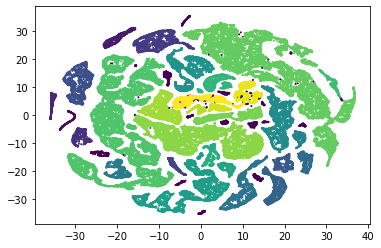

bonsai256X256X256B_23_sparse_pt_vg_logh
cluster num :  38


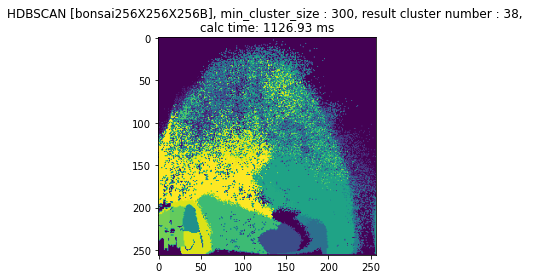

1126.93 ms


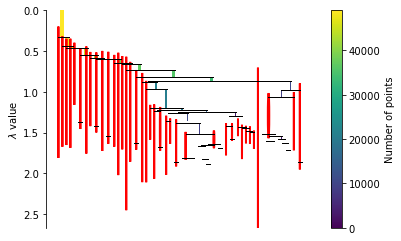

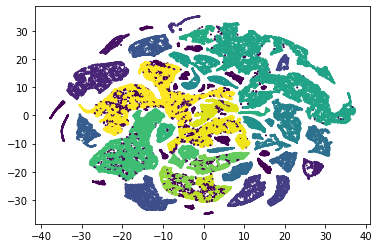

bonsai256X256X256B_24_sparse_pt_vgh
cluster num :  33


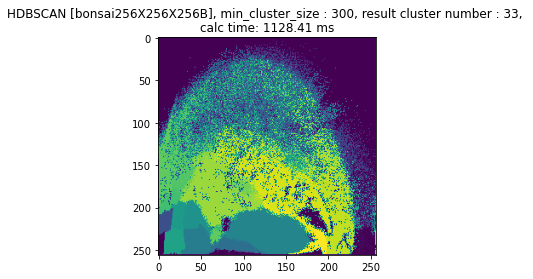

1128.4050000000002 ms


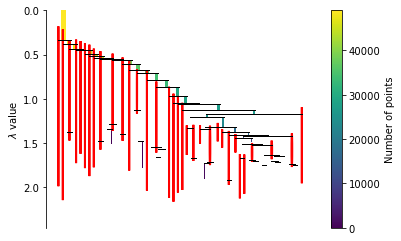

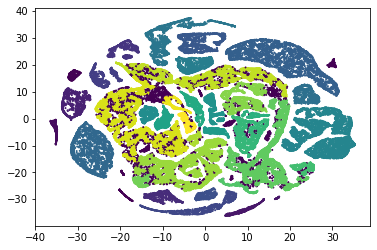

bonsai256X256X256B_25_sparse_pt_vglogh


In [6]:
index = ["vgh", "vglogh", 
         "n_l1_vg_h", "n_l1_vg_logh", "n_l1_vgh", "n_l1_vglogh", 
         "n_l2_vg_h", "n_l2_vg_logh", "n_l2_vgh", "n_l2_vglogh", 
         "n_max_vg_h", "n_max_vg_logh", "n_max_vgh", "n_max_vglogh", 
         "std_vg_h", "std_vg_logh", "std_vgh", "std_vglogh", 
         "mm_vg_h", "mm_vg_logh", "mm_vgh", "mm_vglogh", 
         "pt_vg_h", "pt_vg_logh", "pt_vgh", "pt_vglogh"
        ]

w=256
h=256
size = w*h

all_val_grad_hist = []
sparse_val_grad_hist = []

for dataset in ['bonsai256X256X256B'] :
    with open('../volumeCache/%s.raw.2DHistogram.TextureCache'%(dataset), 'rb') as fp:
        Histogram2DYMax = unpack('<f', fp.read(4))[0] #Max of Grad_mag
        for i in range(h) :
            for j in range(w):
                readdata = unpack('<L', fp.read(4))[0]
                all_val_grad_hist.append([i, j, readdata])
                if readdata>=1 and i!=0:
                    sparse_val_grad_hist.append([i, j, readdata])

        np_all_val_grad_hist = np.array(all_val_grad_hist)
        np_sparse_val_grad_hist = np.array(sparse_val_grad_hist)

        ret_all_array = transform(np_all_val_grad_hist)
        ret_sparse_array = transform(np_sparse_val_grad_hist)
        
        tsne_all_array = []
        tsne_sparse_array = []
        for i in range(len(ret_sparse_array)):
            print("%s_%d_sparse_%s"% ( dataset, i,index[i]), end='\t')
            tsne_sparse_array.append(_TSNE(100,ret_sparse_array[i]))
            
        for i in range(len(tsne_sparse_array)):
            save_tsne_result( tsne_sparse_array[i],  "tsneCache", "%s_%d_sparse_%s"% (dataset,i,  index[i]) )     
        
        
        for i in range(len(tsne_sparse_array)):
            Hdbscan(300, 20, 1.0, tsne_sparse_array[i], np_sparse_val_grad_hist, 256,256,  "%s_%d_sparse_%s"% ( dataset, i,index[i])  ) # *
